In [1]:
!pip install -q nltk

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

In [3]:
import sys
sys.path.append("../../../../")
import torch
from torch import nn
from torch.optim import AdamW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pricer.evaluate import evaluate
from pricer.items import Item
from tqdm.notebook import tqdm

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
device

'cuda'

In [6]:
LITE_MODE = False
username = "ed-donner"
dataset = f"{username}/items_lite" if LITE_MODE else f"{username}/items_full"
train, val, test = Item.get_from_hub(dataset)
print(f"Loaded {len(train):,} training items, {len(val):,} validation items, {len(test):,} test items")

Loaded 800,000 training items, 10,000 validation items, 10,000 test items


In [7]:
test[0].summary

'Title: Excess V2 Distortion/Modulation Pedal  \nCategory: Music Pedals  \nBrand: Old Blood Noise  \nDescription: A versatile pedal offering distortion and three modulation modes—delay, chorus, and harmonized fifths—with full control over signal routing and expression.  \nDetails: Features include separate gain, tone, and volume controls; time, depth, and volume per modulation; order switching, soft‑touch bypass, and expression jack for dynamic control.'

In [8]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
def get_dataframe(train,val,test):
    train_df = [{"text": item.summary, "price": float(item.price)} for item in tqdm(train)]
    val_df = [{"text": item.summary , "price": float(item.price)} for item in tqdm(val)]
    test_df = [{"text": item.summary , "price": float(item.price)} for item in tqdm(test)]
    return pd.DataFrame(train_df),pd.DataFrame(val_df),pd.DataFrame(test_df)

In [10]:
texts = [item.summary  for item in train]

In [11]:
# texts

In [12]:
from nltk.tokenize import word_tokenize

In [13]:
def tokenize_items(dataset):
    sequences = []
    prices = []
    for item in dataset:
        text = str(item.summary)
        tokens = word_tokenize(text.lower())
        sequences.append(tokens)
        prices.append(float(item.price))
    return sequences, prices

train_sequences, train_prices = tokenize_items(train)
val_sequences, val_prices = tokenize_items(val)
test_sequences, test_prices = tokenize_items(test)

In [14]:
from collections import Counter

word_counts = Counter(word for tokens in train_sequences for word in tokens)
vocab_size = 10000
most_common = word_counts.most_common(vocab_size - 2)
word2idx = {word: idx+2 for idx, (word, _) in enumerate(most_common)}
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1
idx2word = {idx: word for word, idx in word2idx.items()}

In [15]:
idx2word = {idx: word for word, idx in word2idx.items()}

In [16]:
def text_to_sequence(tokens, word2idx, max_len=150):
    seq = [word2idx.get(word, 1) for word in tokens]
    return seq[:max_len] + [0] * max(0, max_len - len(seq))

train_idx = [text_to_sequence(t, word2idx) for t in train_sequences]
val_idx   = [text_to_sequence(t, word2idx) for t in val_sequences]
test_idx  = [text_to_sequence(t, word2idx) for t in test_sequences]


In [17]:

X_train = torch.tensor(train_idx, dtype=torch.long)
X_val   = torch.tensor(val_idx,   dtype=torch.long)
X_test  = torch.tensor(test_idx,  dtype=torch.long)

y_train = torch.tensor(train_prices, dtype=torch.float32)
y_val   = torch.tensor(val_prices,   dtype=torch.float32)
y_test  = torch.tensor(test_prices,  dtype=torch.float32)


In [18]:
def compute_lengths(x):
    return (x != 0).sum(dim=1)

train_lengths = compute_lengths(X_train)
val_lengths   = compute_lengths(X_val)
test_lengths  = compute_lengths(X_test)


In [19]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence

class TextRNNRegressor(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=128,
        hidden_dim=128,
        dropout=0.1
    ):
        super().__init__()

        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
            padding_idx=0
        )

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            batch_first=True
        )

        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x, lengths):
        emb = self.embedding(x)

        packed = pack_padded_sequence(
            emb,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        _, (h_n, _) = self.lstm(packed)

        last_hidden = h_n[-1]          # [batch, hidden_dim]
        out = self.regressor(last_hidden)

        return out.squeeze(1)


In [20]:
vocab_size = len(word2idx)  # 10000 + 2 special tokens
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextRNNRegressor(vocab_size=len(word2idx)).to(device)

In [21]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_dataset = TensorDataset(X_train, train_lengths, y_train)
val_dataset   = TensorDataset(X_val,   val_lengths,   y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32)

In [22]:
EPOCHS = 100
PATIENCE = 10
BATCH_SIZE = 128


In [24]:
train_losses = []
val_losses = []

best_val_loss = float("inf")
counter = 0  # early stopping counter

for epoch in range(1, EPOCHS + 1):
    # -------- TRAIN --------
    model.train()
    running_train_loss = 0.0

    for X_batch, lengths_batch, y_batch in tqdm(
        train_loader, desc=f"Epoch {epoch} [train]"
    ):
        X_batch = X_batch.to(device)
        lengths_batch = lengths_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        preds = model(X_batch, lengths_batch)
        loss = criterion(preds, y_batch)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # -------- VALIDATION --------
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for X_batch, lengths_batch, y_batch in tqdm(
            val_loader, desc=f"Epoch {epoch} [val]"
        ):
            X_batch = X_batch.to(device)
            lengths_batch = lengths_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(X_batch, lengths_batch)
            loss = criterion(preds, y_batch)

            running_val_loss += loss.item() * X_batch.size(0)

    epoch_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"Train MSE: {epoch_train_loss:.4f} | "
        f"Val MSE: {epoch_val_loss:.4f}"
    )

    # -------- EARLY STOPPING --------
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_rnn_model.pt")
    else:
        counter += 1
        if counter >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch}")
            break


Epoch 1 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 1 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/100 | Train MSE: 14372.7327 | Val MSE: 10805.8315


Epoch 2 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 2 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/100 | Train MSE: 10696.3270 | Val MSE: 10233.3763


Epoch 3 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 3 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/100 | Train MSE: 9595.3108 | Val MSE: 9917.5434


Epoch 4 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 4 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/100 | Train MSE: 8849.6937 | Val MSE: 10099.6405


Epoch 5 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 5 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/100 | Train MSE: 8211.7601 | Val MSE: 10033.0622


Epoch 6 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 6 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/100 | Train MSE: 7706.8550 | Val MSE: 9821.1706


Epoch 7 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 7 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/100 | Train MSE: 7287.6096 | Val MSE: 10109.4899


Epoch 8 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 8 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/100 | Train MSE: 6944.9832 | Val MSE: 9978.6072


Epoch 9 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 9 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9/100 | Train MSE: 6677.7827 | Val MSE: 10223.8025


Epoch 10 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 10 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10/100 | Train MSE: 6472.1232 | Val MSE: 10147.6170


Epoch 11 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 11 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11/100 | Train MSE: 6260.8609 | Val MSE: 10269.9764


Epoch 12 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 12 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12/100 | Train MSE: 6109.6277 | Val MSE: 10635.3920


Epoch 13 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 13 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13/100 | Train MSE: 5959.1121 | Val MSE: 10158.1395


Epoch 14 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 14 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14/100 | Train MSE: 5815.3154 | Val MSE: 10526.1400


Epoch 15 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 15 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15/100 | Train MSE: 5729.9287 | Val MSE: 10210.2826


Epoch 16 [train]:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 16 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16/100 | Train MSE: 5640.9351 | Val MSE: 10391.1354
Early stopping triggered at epoch 16


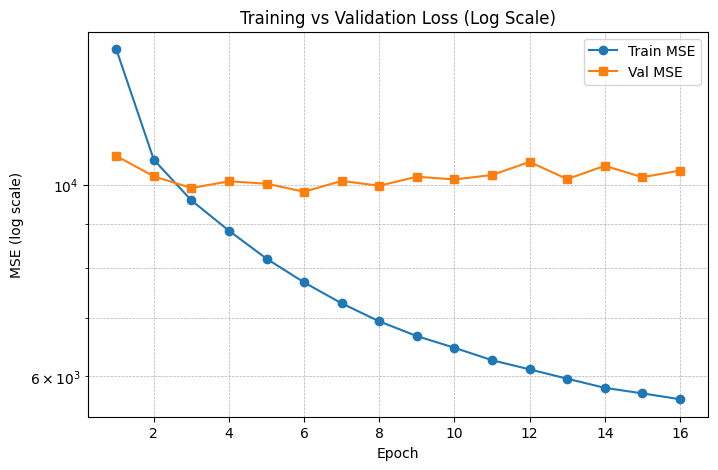

In [25]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))

plt.plot(epochs, train_losses, label="Train MSE", marker="o")
plt.plot(epochs, val_losses, label="Val MSE", marker="s")

plt.yscale("log")  # logarithmic loss scale
plt.xlabel("Epoch")
plt.ylabel("MSE (log scale)")
plt.title("Training vs Validation Loss (Log Scale)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()


In [27]:
loaded_model = TextRNNRegressor(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=128,
    dropout=0.1
)

# ---- load trained weights ----
loaded_model.load_state_dict(torch.load("best_rnn_model.pt", map_location=device))
loaded_model.to(device)
loaded_model.eval()

TextRNNRegressor(
  (embedding): Embedding(10000, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True)
  (regressor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [28]:
def predict_RNN(item):
    max_len = 150

    with torch.no_grad():
        # tokenize
        tokens = word_tokenize(
            item.summary.lower()
        )

        # convert to indices
        seq = [word2idx.get(word, 1) for word in tokens]  # <UNK> = 1

        # length before padding
        length = min(len(seq), max_len)

        # pad / truncate
        if len(seq) < max_len:
            seq += [0] * (max_len - len(seq))
        else:
            seq = seq[:max_len]

        # tensors
        x = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)   # [1, max_len]
        lengths = torch.tensor([length], dtype=torch.long).to(device)    # [1]

        # predict
        output = loaded_model(x, lengths).cpu().item()

    return output

In [29]:
evaluate(predict_RNN, test)

  0%|          | 0/200 [00:00<?, ?it/s]

$24 $59 $25 $46 $71 $118 $96 $22 $30 $97 $22 $104 $38 $95 $24 $8 $47 $12 $39 $22 $48 $23 $7 $67 $175 $149 $176 $24 $57 $60 $104 $53 $56 $21 $9 $195 $83 $16 $107 $5 $109 $44 $13 $64 $36 $32 $17 $14 $25 $14 $24 $1 $120 $55 $71 $67 $32 $135 $63 $47 $46 $23 $31 $16 $469 $23 $3 $275 $1 $180 $4 $14 $61 $57 $11 $23 $155 $17 $29 $44 $63 $39 $37 $52 $54 $57 $106 $25 $46 $198 $16 $33 $4 $3 $13 $21 $2 $72 $133 $176 $12 $7 $4 $32 $0 $45 $27 $236 $8 $84 $18 $5 $46 $10 $23 $78 $32 $12 $18 $151 $27 $193 $16 $18 $64 $20 $21 $21 $43 $29 $74 $54 $6 $1 $78 $31 $84 $22 $36 $26 $3 $21 $29 $63 $47 $25 $1 $285 $15 $10 $23 $23 $6 $71 $32 $113 $121 $15 $19 $6 $23 $9 $2 $16 $138 $14 $3 $27 $19 $35 $31 $13 $138 $24 $27 $38 $20 $69 $52 $1 $89 $23 $40 $68 $11 $15 $69 $91 $10 $26 $45 $49 $7 $126 $10 $270 $52 $12 $2 $13 